# CNN model training for all DEFRA stations

This notebook trains convolutional neural network (CNN) models to predict air pollution levels across ALL DEFRA UK-AIR monitoring stations. I train CNN models for every station pollutant combination in the DEFRA dataset.

The goal is to compare network wide CNN performance against the random forest results from rf_training_defra_all.ipynb.

## Why all stations instead of one?

The single station approach was useful for proof of concept. The dissertation needs to show how the models perform across the entire DEFRA network. This means training separate models for each station pollutant combination.


## Structure of notebook:

| Section | What it does                                |
| ------- | ------------------------------------------- |
| 1       | Setup and imports                           |
| 2       | Load prepared data `ml_prep_all`            |
| 3       | Understanding data shapes                   |
| 4       | Identify all target columns                 |
| 5       | Build CNN model function                    |
| 6       | Set-up training callbacks                   |
| 7       | Train models for all targets with callbacks |
| 8       | Load results training output                |
| 9       | Investigation of broken models              |
| 10      | Baseline evaluation after exclusion         |
| 11      | Results summary and save                    |
| 12      | Prediction visualisations                   |
| 13      | Residual analysis                           |
| 14      | Final summary                               |

## 

## 1) Setup and imports

Importing everything needed for CNN training. Tensorflow/keras handles the neural network numpy for arrays matplotlib and seaborn for plotting scikit learn for metrics.

In [12]:
#Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
import time
import gc
from collections import Counter
warnings.filterwarnings('ignore')

#Scikit learn for metrics r2, MSE, MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Tensorflow and keras for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.16.2


Tensorflow version: 2.16.2

In [13]:
#Paths
base_dir = Path.cwd().parent.parent / 'data' / 'defra'
data_dir = base_dir / 'ml_prep_all'
output_dir = Path.cwd().parent.parent / 'data' / 'ml' / 'DEFRA_all' / 'cnn_model'
output_dir.mkdir(parents=True, exist_ok=True)

print(f'Loading data from: {data_dir}')
print(f'Saving outputs to: {output_dir}')

Loading data from: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep_all
Saving outputs to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all/cnn_model


    Loading data from: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep_all
    Saving outputs to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all/cnn_model

### GPU availability

Checking if GPU is available. CNN training is faster on GPU but will still work on CPU.

Source: Use a GPU: Tensorflow Core (no date) TensorFlow. Available at: https://www.tensorflow.org/guide/gpu

In [14]:
#Check gpu availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f'GPU available: {len(gpus)} device(s)')
    for gpu in gpus:
        print(f'  - {gpu.name}')
else:
    print('No GPU found, using CPU training will be slower but still works.')

No GPU found, using CPU training will be slower but still works.


No GPU found, using CPU training will be slower but still works.

## 2) Load prepared data `ml_prep_all`

The data was prepared in `ml_prep_defra_all.ipynb` it created sequences where each sample has 12 hours of history to predict the next hour for all stations.

### Why 3D data for CNN?

Random forest needs flat 2D data: (samples, features). CNN needs 3D data: (samples, timesteps, features). The 3D shape lets CNN learn patterns across time, not just treat each timestep as an independent feature.


| Data shape | Model | Structure |
|------------|-------|----------|
| 2D | Random forest | each row is a flat list of numbers with no structure |
| 3D | CNN | each sample is a grid where rows are hours and columns are features |

In [15]:
#Load the 3d sequences for cnn
X_train = np.load(data_dir / 'X_train.npy')
X_val = np.load(data_dir / 'X_val.npy')
X_test = np.load(data_dir / 'X_test.npy')

y_train = np.load(data_dir / 'y_train.npy')
y_val = np.load(data_dir / 'y_val.npy')
y_test = np.load(data_dir / 'y_test.npy')

#Load feature_names and scaler
feature_names = joblib.load(data_dir / 'feature_names.joblib')
scaler = joblib.load(data_dir / 'scaler.joblib')

print('Data loaded successfully.')
print(f'\nShapes:')
print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_val: {y_val.shape}')
print(f'y_test: {y_test.shape}')

Data loaded successfully.

Shapes:
X_train: (17036, 12, 44)
X_val: (3641, 12, 44)
X_test: (3642, 12, 44)
y_train: (17036, 44)
y_val: (3641, 44)
y_test: (3642, 44)


    Data loaded successfully.

    Shapes:
    X_train: (17036, 12, 44)
    X_val: (3641, 12, 44)
    X_test: (3642, 12, 44)
    y_train: (17036, 44)
    y_val: (3641, 44)
    y_test: (3642, 44)

## 3) Understanding data shapes

X_train shape:

| Dimension | What it represents |
|-----------|--------------|
| First | number of samples (individual training examples) |
| Second | timesteps (12 hours of history) |
| Third | features (all station pollutant columns + temporal) |

y_train shape is (samples, features). The model can predict all features for the next hour.

In [16]:
#Extract dimensions
n_samples, timesteps, n_features = X_train.shape

print(f'\nData dimensions:')
print(f'  Samples: {n_samples:,}')
print(f'  Timesteps: {timesteps}')
print(f'  Features: {n_features}')
print(f'\nFeature names ({len(feature_names)} total):')
print(f'  First 10: {feature_names[:10]}')
print(f'  Last 10: {feature_names[-10:]}')


Data dimensions:
  Samples: 17,036
  Timesteps: 12
  Features: 44

Feature names (44 total):
  First 10: ['Borehamwood_Meadow_Park_NO2', 'Borehamwood_Meadow_Park_PM10', 'Borehamwood_Meadow_Park_PM25', 'Camden_Kerbside_NO2', 'Haringey_Roadside_NO2', 'London_Bexley_NO2', 'London_Bexley_PM10', 'London_Bloomsbury_NO2', 'London_Bloomsbury_O3', 'London_Bloomsbury_PM10']
  Last 10: ['London_Teddington_Bushy_Park_PM25', 'London_Westminster_NO2', 'London_Westminster_O3', 'London_Westminster_PM25', 'Southwark_A2_Old_Kent_Road_NO2', 'Tower_Hamlets_Roadside_NO2', 'hour', 'day_of_week', 'month', 'is_weekend']


    Data dimensions:
    Samples: 17,036
    Timesteps: 12
    Features: 44

    Feature names (44 total):
    First 10: ['Borehamwood_Meadow_Park_NO2', 'Borehamwood_Meadow_Park_PM10', 'Borehamwood_Meadow_Park_PM25', 'Camden_Kerbside_NO2', 'Haringey_Roadside_NO2', 'London_Bexley_NO2', 'London_Bexley_PM10', 'London_Bloomsbury_NO2', 'London_Bloomsbury_O3', 'London_Bloomsbury_PM10']
    Last 10: ['London_Teddington_Bushy_Park_PM25', 'London_Westminster_NO2', 'London_Westminster_O3', 'London_Westminster_PM25', 'Southwark_A2_Old_Kent_Road_NO2', 'Tower_Hamlets_Roadside_NO2', 'hour', 'day_of_week', 'month', 'is_weekend']

## 4) Identify all target columns

Need to identify which columns are pollutant predictions (targets) and which are temporal features. Temporal features like hour, day_of_week are inputs only, not things we want to predict.

### Pollutant naming convention

Each target column follows the pattern: `{StationName}_{PollutantCode}`

Example:

| Example | Meaning |
|---------|--------|
| London_Bloomsbury_NO2 | NO2 at London Bloomsbury station |
| London_Marylebone_Road_PM25 | PM2.5 at London Marylebone Road station |

### The 6 regulatory pollutants:

| Pollutant | Code | UK annual limit |
|-----------|------|----------------|
| Nitrogen Dioxide | NO2 | 40 ug/m3 |
| PM2.5 Particulate | PM25 | 20 ug/m3 |
| PM10 Particulate | PM10 | 40 ug/m3 |
| Ozone | O3 | n/a |
| Sulphur Dioxide | SO2 | n/a |
| Carbon Monoxide | CO | n/a |

Source: Department for Environment, Food and Rural Affairs (2019) UK Air Quality Objectives

In [17]:
#Identify temporal vs pollutant columns
temporal_cols = ['hour', 'day_of_week', 'month', 'is_weekend']

#Get pollutant target columns (everything except temporal)
target_names = [name for name in feature_names if name not in temporal_cols]
target_indices = [i for i, name in enumerate(feature_names) if name not in temporal_cols]

#Create target mapping dictionary
target_mapping = {name: i for i, name in enumerate(feature_names) if name not in temporal_cols}

print(f'Total features: {len(feature_names)}')
print(f'Temporal features: {len(temporal_cols)}')
print(f'Pollutant targets: {len(target_names)}')

#Count by pollutant type
pollutant_codes = ['NO2', 'PM25', 'PM10', 'O3', 'SO2', 'CO']
print(f'\nBreakdown by pollutant:')
for poll in pollutant_codes:
    count = len([n for n in target_names if f'_{poll}' in n])
    print(f'  {poll}: {count} stations')

Total features: 44
Temporal features: 4
Pollutant targets: 40

Breakdown by pollutant:
  NO2: 13 stations
  PM25: 7 stations
  PM10: 7 stations
  O3: 8 stations
  SO2: 3 stations
  CO: 2 stations


    Total features: 44
    Temporal features: 4
    Pollutant targets: 40

    Breakdown by pollutant:
    NO2: 13 stations
    PM25: 7 stations
    PM10: 7 stations
    O3: 8 stations
    SO2: 3 stations
    CO: 2 stations

## 5) Build CNN model function

Building a function that creates CNN models. Using the best hyperparameters found from the DEFRA single station tuning:

| Parameter | Value | Why |
|-----------|-------|-----|
| filters_1 | 32 | DEFRA needs simpler model with fewer features |
| kernel_1 | 2 | short term patterns matter most |
| dropout_1 | 0.1 | light regularisation after first conv |
| filters_2 | 16 | second layer with fewer filters |
| kernel_2 | 2 | consistent with first layer |
| dropout_2 | 0.2 | moderate regularisation after second conv |
| dense_units | 25 | smaller dense layer for simpler data |
| dropout_3 | 0.3 | stronger regularisation before output |
| learning_rate | 0.001 | adam default works well |

These parameters came from keras tuner results in the DEFRA single station CNN notebook. DEFRA requires a simpler architecture than LAQN because it has fewer features.

Source: Geron, A. (2023) Hands on machine learning with scikit learn, Keras and TensorFlow. Ch. 15.

In [18]:
def build_cnn_model(timesteps, 
                    features, 
                    filters_1=32, 
                    filters_2=16,
                    kernel_size=2, 
                    dropout_1=0.1, 
                    dropout_2=0.2, 
                    dropout_3=0.3,
                    dense_units=25, 
                    learning_rate=0.001):
    """
    Build a 1D CNN for time series prediction.
    Based on tuned hyperparameters from DEFRA single station experiment.

    Params:
        timesteps: number of historical hours (12)
        features: number of input features
        filters_1: filters in first conv layer (32 for DEFRA)
        filters_2: filters in second conv layer (16 for DEFRA)
        kernel_size: size of convolutional kernel
        dropout_1: dropout rate after first conv (0.1)
        dropout_2: dropout rate after second conv (0.2)
        dropout_3: dropout rate before output (0.3)
        dense_units: neurons in dense layer (25 for DEFRA)
        learning_rate: adam learning rate

    Returns:
        compiled keras model
    """
    model = models.Sequential([
        #Input layer
        layers.Input(shape=(timesteps, features)),

        #First conv layer
        layers.Conv1D(
            filters=filters_1,
            kernel_size=kernel_size,
            activation='relu',
            padding='causal'
        ),
        layers.Dropout(dropout_1),

        #Second conv layer
        layers.Conv1D(
            filters=filters_2,
            kernel_size=kernel_size,
            activation='relu',
            padding='causal'
        ),
        layers.Dropout(dropout_2),

        #Flatten and dense for final prediction
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_3),

        #Output layer single value prediction
        layers.Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0),
        loss='mse',
        metrics=['mae']
    )

    return model

In [19]:
#Test model creation
test_model = build_cnn_model(timesteps, n_features)
print(f'Model created with {test_model.count_params():,} parameters')
test_model.summary()

Model created with 8,739 parameters


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 12, 32)         │         2,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 12, 16)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         4,825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,739 (34.14 KB)

 Trainable params: 8,739 (34.14 KB)

 Non-trainable params: 0 (0.00 B)

Model created with 66,341 parameters

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold">Model: "sequential"</span>
</pre>

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv1D</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">12</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>)         │         <span style="color: #00af00; text-decoration-color: #00af00">2,848</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dropout</span>)             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">12</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>)         │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv1D</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">12</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>)         │         <span style="color: #00af00; text-decoration-color: #00af00">1,040</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dropout</span>)             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">12</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>)         │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>)             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">192</span>)            │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">25</span>)             │         <span style="color: #00af00; text-decoration-color: #00af00">4,825</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dropout</span>)             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">25</span>)             │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">26</span> │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Trainable params: </span><span style="color: #00af00; text-decoration-color: #00af00">8,739</span> (34.14 KB)
</pre>

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Non-trainable params: </span><span style="color: #00af00; text-decoration-color: #00af00">0</span> (0.00 B)
</pre>

### Understanding the summary

The summary shows each layer, its output shape, and parameter count.

| Term | Meaning |
|------|--------|
| param # | number of learnable weights. more parameters = more capacity to learn, but also more risk of overfitting |
| output shape | (None, timesteps, filters). None is batch size, determined at runtime |
| total params | all weights the model will learn during training |

## 6) Set-up training callbacks

Callbacks control training behaviour.

| Callback | What it does | Why |
|----------|--------------|-----|
| EarlyStopping | stops when validation loss stops improving | prevents overfitting |
| ReduceLROnPlateau | reduces learning rate when stuck | helps find better minimum |

Not using ModelCheckpoint for each model because of multiple targets. Saving checkpoints manually every N models instead.

Source: Team, K. (no date) Keras Documentation: Callbacks. Available at: https://keras.io/api/callbacks/

In [20]:
def get_callbacks():
    """Create callbacks for training."""
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=0
        )
    ]

print('Callbacks configured:')
print('Early stopping (patience=10)')
print('Reduce LR on plateau (factor=0.5, patience=5)')

Callbacks configured:
Early stopping (patience=10)
Reduce LR on plateau (factor=0.5, patience=5)


    Callbacks configured:
    Early stopping (patience=10)
    Reduce LR on plateau (factor=0.5, patience=5)

## 7) Train models for all targets

Training a separate CNN model for each target. This will take a while because:

| Aspect | Detail |
|--------|--------|
| Targets | station pollutant combinations |
| Epochs per model | up to 50 (early stopping) |


### Checkpoint

Saving results every 20 models in case something goes wrong. This way if the notebook crashes, I do not lose everything.


Source: Geron, A. (2023) Hands on machine learning with scikit learn, Keras and TensorFlow. Ch. 11.

In [21]:
#Training configuration
BATCH_SIZE = 32
MAX_EPOCHS = 50
CHECKPOINT_EVERY = 20

print(f'Training configuration:')
print(f'  Batch size: {BATCH_SIZE}')
print(f'  Max epochs: {MAX_EPOCHS}')
print(f'  Checkpoint every: {CHECKPOINT_EVERY} models')
print(f'  Total targets: {len(target_names)}')

Training configuration:
  Batch size: 32
  Max epochs: 50
  Checkpoint every: 20 models
  Total targets: 40


    Training configuration:
    Batch size: 32
    Max epochs: 50
    Checkpoint every: 20 models
    Total targets: 40

In [22]:
#Training loop
results = []
all_models = {}

start_time = time.time()
print(f'Started at: {time.strftime("%Y-%m-%d %H:%M:%S")}')
print(f'Targets to train: {len(target_names)}')
print(f'Training samples: {n_samples:,}')
print(f'Features: {n_features}')
print('=' * 40)

for i, target_name in enumerate(target_names):
    target_idx = target_mapping[target_name]
    model_start = time.time()

    #Build fresh model
    model = build_cnn_model(timesteps, n_features)

    #Train
    history = model.fit(
        X_train, y_train[:, target_idx],
        validation_data=(X_val, y_val[:, target_idx]),
        epochs=MAX_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=get_callbacks(),
        verbose=0
    )

    #Evaluate on test set
    y_pred = model.predict(X_test, verbose=0).flatten()
    y_actual = y_test[:, target_idx]

    test_r2 = r2_score(y_actual, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    test_mae = mean_absolute_error(y_actual, y_pred)

    #Extract pollutant from target name
    parts = target_name.rsplit('_', 1)
    pollutant = parts[1] if len(parts) > 1 else 'unknown'
    site = parts[0] if len(parts) > 1 else target_name

    results.append({
        'target': target_name,
        'pollutant': pollutant,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'epochs': len(history.history['loss']),
        'site': site
    })

    #Store model
    all_models[target_name] = model

    #Progress update
    elapsed = time.time() - model_start
    remaining = len(target_names) - (i + 1)
    eta = (elapsed * remaining) / 60
    print(f'[{i+1:3d}/{len(target_names)}] {target_name:40s} | R2={test_r2:.3f} | Time={elapsed:.0f}s | ETA={eta:.0f}min')

    #Checkpoint
    if (i + 1) % CHECKPOINT_EVERY == 0:
        checkpoint_df = pd.DataFrame(results)
        checkpoint_df.to_csv(output_dir / f'checkpoint_{i+1}.csv', index=False)
        print(f'   [Checkpoint saved at {i+1} models]')

    #Memory cleanup
    tf.keras.backend.clear_session()
    gc.collect()

total_time = (time.time() - start_time) / 60
print('=' * 40)
print('Training complete!')
print(f'Total time: {total_time:.1f} minutes ({total_time/60:.2f} hours)')
print(f'Average per model: {total_time*60/len(target_names):.1f} seconds')

Started at: 2026-01-02 23:22:21
Targets to train: 40
Training samples: 17,036
Features: 44
[  1/40] Borehamwood_Meadow_Park_NO2              | R2=0.807 | Time=30s | ETA=19min
[  2/40] Borehamwood_Meadow_Park_PM10             | R2=0.792 | Time=19s | ETA=12min
[  3/40] Borehamwood_Meadow_Park_PM25             | R2=0.830 | Time=18s | ETA=11min
[  4/40] Camden_Kerbside_NO2                      | R2=0.665 | Time=22s | ETA=13min
[  5/40] Haringey_Roadside_NO2                    | R2=0.772 | Time=18s | ETA=10min
[  6/40] London_Bexley_NO2                        | R2=0.764 | Time=18s | ETA=10min
[  7/40] London_Bexley_PM10                       | R2=0.735 | Time=21s | ETA=12min
[  8/40] London_Bloomsbury_NO2                    | R2=0.791 | Time=15s | ETA=8min
[  9/40] London_Bloomsbury_O3                     | R2=0.851 | Time=28s | ETA=15min
[ 10/40] London_Bloomsbury_PM10                   | R2=0.664 | Time=23s | ETA=11min
[ 11/40] London_Bloomsbury_PM25                   | R2=0.814 | Time=21

In [23]:
#Save models and results after training completes
joblib.dump(all_models, output_dir / 'cnn_all_models.joblib')
print(f'Saved {len(all_models)} models')

Saved 40 models


## 8) Load results training output

Loading the results from the training output.

In [24]:
#Load results from training output if training just completed, results should be in the 'results' variable

results_file = output_dir / 'cnn_results_local.csv'

if 'results' in dir() and len(results) > 0:
    #Use results from current training session
    results_df = pd.DataFrame(results)
    print(f'Using results from current training session')
    print(f'Loaded {len(results_df)} results')
    
elif results_file.exists():
    #Load from saved csv
    results_df = pd.read_csv(results_file)
    print(f'Loaded results from: {results_file}')
    print(f'Loaded {len(results_df)} results')
    
else:
    print('No results found!')
    print('Either run the training loop or check the output directory')

Using results from current training session
Loaded 40 results


In [25]:
#Verify results dataframe structure
print('Results dataframe')
print('=' * 40)

#Check if required columns exist, add if missing
if 'site' not in results_df.columns:
    results_df['site'] = results_df['target'].apply(lambda x: x.rsplit('_', 1)[0])
    
if 'pollutant' not in results_df.columns:
    results_df['pollutant'] = results_df['target'].apply(lambda x: x.rsplit('_', 1)[1])

print(f'Shape: {results_df.shape}')
print(f'\nColumns: {list(results_df.columns)}')
print(f'\nFirst 5 rows:')
print(results_df.head().to_string(index=False))

#Save results
results_df.to_csv(output_dir / 'cnn_results_local.csv', index=False)
print(f'\nResults saved to: {output_dir / "cnn_results_local.csv"}')

Results dataframe
Shape: (40, 7)

Columns: ['target', 'pollutant', 'test_r2', 'test_rmse', 'test_mae', 'epochs', 'site']

First 5 rows:
                      target pollutant  test_r2  test_rmse  test_mae  epochs                    site
 Borehamwood_Meadow_Park_NO2       NO2 0.806811   0.042824  0.027767      50 Borehamwood_Meadow_Park
Borehamwood_Meadow_Park_PM10      PM10 0.792003   0.020059  0.015124      31 Borehamwood_Meadow_Park
Borehamwood_Meadow_Park_PM25      PM25 0.830072   0.015022  0.010926      33 Borehamwood_Meadow_Park
         Camden_Kerbside_NO2       NO2 0.665247   0.057131  0.043392      38         Camden_Kerbside
       Haringey_Roadside_NO2       NO2 0.771961   0.033220  0.024728      28       Haringey_Roadside

Results saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all/cnn_model/cnn_results_local.csv


    Results dataframe
    ========================================
    Shape: (40, 7)

    Columns: ['target', 'pollutant', 'test_r2', 'test_rmse', 'test_mae', 'epochs', 'site']

    First 5 rows:
                        target pollutant  test_r2  test_rmse  test_mae  epochs                    site
    Borehamwood_Meadow_Park_NO2       NO2 0.806811   0.042824  0.027767      50 Borehamwood_Meadow_Park
    Borehamwood_Meadow_Park_PM10      PM10 0.792003   0.020059  0.015124      31 Borehamwood_Meadow_Park
    Borehamwood_Meadow_Park_PM25      PM25 0.830072   0.015022  0.010926      33 Borehamwood_Meadow_Park
            Camden_Kerbside_NO2       NO2 0.665247   0.057131  0.043392      38         Camden_Kerbside
        Haringey_Roadside_NO2       NO2 0.771961   0.033220  0.024728      28       Haringey_Roadside

    Results saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all/cnn_model/cnn_results_local.csv

## 9) Investigation of broken models

Some models may produce extremely negative R2 values, indicating numerical issues. Before continuing with results analysis, I need to investigate and document these failures.

In [26]:
#Identify broken models
print('Identifying broken models')
print('=' * 40)

#Broken threshold: R2 < -10 is clearly numerical failure
broken_threshold = -10

broken_models = results_df[results_df['test_r2'] < broken_threshold].copy()
valid_models = results_df[results_df['test_r2'] >= broken_threshold].copy()

print(f'\nTotal models:  {len(results_df)}')
print(f'Valid models:  {len(valid_models)}')
print(f'Broken models: {len(broken_models)}')

if len(broken_models) > 0:
    print('\n' + '-' * 40)
    print('Broken models:')
    print('-' * 40)
    print(broken_models[['target', 'pollutant', 'test_r2']].to_string(index=False))
else:
    print('\nNo broken models found.')

Identifying broken models

Total models:  40
Valid models:  39
Broken models: 1

----------------------------------------
Broken models:
----------------------------------------
                    target pollutant       test_r2
Tower_Hamlets_Roadside_NO2       NO2 -8.279772e+29


    Identifying broken models
    ========================================

    Total models:  40
    Valid models:  39
    Broken models: 1

    ----------------------------------------
    Broken models:
    ----------------------------------------
                        target pollutant       test_r2
    Tower_Hamlets_Roadside_NO2       NO2 -8.279772e+29

In [27]:
#Investigate broken models by checking test set variance
if len(broken_models) > 0:
    print('Detailed investigation of broken models:')
    print('=' * 40)

    broken_targets = broken_models['target'].values

    for target in broken_targets:
        print(f'\n>>> {target}')
        print('-' * 40)

        target_idx = target_mapping[target]

        #Check target data statistics
        y_train_target = y_train[:, target_idx]
        y_val_target = y_val[:, target_idx]
        y_test_target = y_test[:, target_idx]

        print(f'Training   - min: {y_train_target.min():.6f}, max: {y_train_target.max():.6f}, '
              f'std: {y_train_target.std():.6f}')
        print(f'Validation - min: {y_val_target.min():.6f}, max: {y_val_target.max():.6f}, '
              f'std: {y_val_target.std():.6f}')
        print(f'Test       - min: {y_test_target.min():.6f}, max: {y_test_target.max():.6f}, '
              f'std: {y_test_target.std():.6f}')

        #Check for constant or near constant values
        if y_test_target.std() < 0.001:
            print('>>> Very low variance in test set (std < 0.001)')
else:
    print('No broken models to investigate.')

Detailed investigation of broken models:

>>> Tower_Hamlets_Roadside_NO2
----------------------------------------
Training   - min: 0.000000, max: 1.000000, std: 0.122847
Validation - min: 0.022059, max: 0.827211, std: 0.101201
Test       - min: 0.181988, max: 0.181988, std: 0.000000
>>> Very low variance in test set (std < 0.001)


    Detailed investigation of broken models:
    ========================================

    >>> Tower_Hamlets_Roadside_NO2
    ----------------------------------------
    Training   - min: 0.000000, max: 1.000000, std: 0.122847
    Validation - min: 0.022059, max: 0.827211, std: 0.101201
    Test       - min: 0.181988, max: 0.181988, std: 0.000000
    >>> Very low variance in test set (std < 0.001)

In [28]:
#Root cause analysis
if len(broken_models) > 0:
    print('Root cause analysis of broken models:')
    print('=' * 40)

    broken_targets = broken_models['target'].values

    #Check broken models site
    broken_sites = [t.rsplit('_', 1)[0] for t in broken_targets]
    print(f'\nBroken model sites: {broken_sites}')

    #Count and addup if the sites have multiple failures
    site_counts = Counter(broken_sites)
    multi_broken = {site: count for site, count in site_counts.items() if count > 1}

    if multi_broken:
        print(f'\nSites with multiple broken models: {multi_broken}')
        print('This suggests data quality issues at these monitoring stations.')
else:
    print('No broken models to analyse.')

Root cause analysis of broken models:

Broken model sites: ['Tower_Hamlets_Roadside']


    Root cause analysis of broken models:
    ========================================

    Broken model sites: ['Tower_Hamlets_Roadside']

### Findings: why the model broke?

The investigation shows only 1 broken model out of 40 (2.5%), significantly fewer than LAQN (5 out of 141).

**Root cause: constant target values in test set**

| Target | Test std | Issue |
|--------|----------|-------|
| Tower_Hamlets_Roadside_NO2 | 0.000000 | Constant values |

The broken model has test set standard deviation of exactly zero. All actual values in the test period are identical (0.181988), meaning no variation exists for the model to predict.

When actual values are constant, R2 calculation fails:

R2 = 1 - (SS_res / SS_tot)

Where SS_tot = sum((y_i - y_mean)^2) = 0 when all values are identical. Division by zero produces the extreme negative value (-8.28 × 10^29).

**Affected station:**

| Station | Pollutant | Likely cause |
|---------|-----------|--------------|
| Tower Hamlets Roadside | NO2 | Equipment offline or data gap during test period |

The training data shows normal variation (std = 0.123) and validation has some variation (std = 0.101), but the test period captured a time when the monitor was either offline or stuck at a single reading.

**Decision:** This model is excluded from summary statistics. The remaining 39 models provide valid performance metrics.


## 10) Baseline evaluation after exclusion

Evaluating the valid models, excluding any broken models.

In [29]:
#Baseline evaluation excluding broken models
print('CNN baseline evaluation excluding broken models:')
print('=' * 40)

print(f'\nValid models: {len(valid_models)} out of {len(results_df)}')
print(f'Broken models excluded: {len(broken_models)}')

print('Test set performance with valid models only:')
print('-' * 40)

print(f'\nMean R2:   {valid_models["test_r2"].mean():.4f}')
print(f'Median R2: {valid_models["test_r2"].median():.4f}')
print(f'Std R2:    {valid_models["test_r2"].std():.4f}')
print(f'Min R2:    {valid_models["test_r2"].min():.4f}')
print(f'Max R2:    {valid_models["test_r2"].max():.4f}')

CNN baseline evaluation excluding broken models:

Valid models: 39 out of 40
Broken models excluded: 1
Test set performance with valid models only:
----------------------------------------

Mean R2:   0.6006
Median R2: 0.7720
Std R2:    0.4092
Min R2:    -0.6939
Max R2:    0.9075


    CNN baseline evaluation excluding broken models:
    ========================================

    Valid models: 39 out of 40
    Broken models excluded: 1
    Test set performance with valid models only:
    ----------------------------------------

    Mean R2:   0.6006
    Median R2: 0.7720
    Std R2:    0.4092
    Min R2:    -0.6939
    Max R2:    0.9075

In [30]:
#Performance by pollutant type
print('\nPerformance by pollutant type')
print('=' * 40)

pollutant_summary = valid_models.groupby('pollutant').agg({
    'test_r2': ['mean', 'std', 'min', 'max', 'count']
}).round(4)

pollutant_summary.columns = ['r2_mean', 'r2_std', 'r2_min', 'r2_max', 'n_models']
pollutant_summary = pollutant_summary.sort_values('r2_mean', ascending=False)

print(pollutant_summary.to_string())


Performance by pollutant type
           r2_mean  r2_std  r2_min  r2_max  n_models
pollutant                                           
O3          0.8357  0.0846  0.6413  0.9075         8
CO          0.7933  0.0573  0.7528  0.8339         2
NO2         0.7725  0.0417  0.6652  0.8215        12
PM10        0.5173  0.3414 -0.1497  0.7948         7
PM25        0.4832  0.5068 -0.5418  0.8641         7
SO2        -0.3747  0.3004 -0.6939 -0.0977         3


    Performance by pollutant type
    ========================================
            r2_mean  r2_std  r2_min  r2_max  n_models
    pollutant                                           
    O3          0.8357  0.0846  0.6413  0.9075         8
    CO          0.7933  0.0573  0.7528  0.8339         2
    NO2         0.7725  0.0417  0.6652  0.8215        12
    PM10        0.5173  0.3414 -0.1497  0.7948         7
    PM25        0.4832  0.5068 -0.5418  0.8641         7
    SO2        -0.3747  0.3004 -0.6939 -0.0977         3

In [31]:
#Top and bottom performing models
print('\nTop 10 best performing targets (by R2)')
print('-' * 50)
top_10 = valid_models.nlargest(10, 'test_r2')[['target', 'pollutant', 'test_r2']]
print(top_10.to_string(index=False))

print('\nBottom 10 worst performing targets (by R2)')
print('-' * 50)
bottom_10 = valid_models.nsmallest(10, 'test_r2')[['target', 'pollutant', 'test_r2']]
print(bottom_10.to_string(index=False))


Top 10 best performing targets (by R2)
--------------------------------------------------
                               target pollutant  test_r2
              London_N._Kensington_O3        O3 0.907493
                London_Westminster_O3        O3 0.905601
                 London_Harlington_O3        O3 0.865772
           London_Honor_Oak_Park_PM25      PM25 0.864093
 London_Haringey_Priory_Park_South_O3        O3 0.862920
                 London_Bloomsbury_O3        O3 0.851442
                 London_Hillingdon_O3        O3 0.835073
            London_Marylebone_Road_CO        CO 0.833863
         Borehamwood_Meadow_Park_PM25      PM25 0.830072
London_Haringey_Priory_Park_South_NO2       NO2 0.821528

Bottom 10 worst performing targets (by R2)
--------------------------------------------------
                           target pollutant   test_r2
         London_N._Kensington_SO2       SO2 -0.693942
          London_Westminster_PM25      PM25 -0.541802
            London_Blooms

    Top 10 best performing targets (by R2)
    --------------------------------------------------
                                target pollutant  test_r2
                London_N._Kensington_O3        O3 0.907493
                    London_Westminster_O3        O3 0.905601
                    London_Harlington_O3        O3 0.865772
            London_Honor_Oak_Park_PM25      PM25 0.864093
    London_Haringey_Priory_Park_South_O3        O3 0.862920
                    London_Bloomsbury_O3        O3 0.851442
                    London_Hillingdon_O3        O3 0.835073
                London_Marylebone_Road_CO        CO 0.833863
            Borehamwood_Meadow_Park_PM25      PM25 0.830072
    London_Haringey_Priory_Park_South_NO2       NO2 0.821528

    Bottom 10 worst performing targets (by R2)
    --------------------------------------------------
                            target pollutant   test_r2
            London_N._Kensington_SO2       SO2 -0.693942
            London_Westminster_PM25      PM25 -0.541802
                London_Bloomsbury_SO2       SO2 -0.332654
            London_Harlington_PM10      PM10 -0.149712
        London_Marylebone_Road_SO2       SO2 -0.097652
    London_Teddington_Bushy_Park_PM25      PM25  0.217706
    London_Teddington_Bushy_Park_PM10      PM10  0.358526
            London_Hillingdon_PM10      PM10  0.426836
            London_Hillingdon_PM25      PM25  0.504213
            London_Honor_Oak_Park_O3        O3  0.641303

## 11) Results summary and save

Saving all results to csv files for later analysis and comparison with random forest.

In [32]:
#Save results
results_df.to_csv(output_dir / 'cnn_all_results.csv', index=False)
valid_models.to_csv(output_dir / 'cnn_valid_results.csv', index=False)
if len(broken_models) > 0:
    broken_models.to_csv(output_dir / 'cnn_broken_models.csv', index=False)
pollutant_summary.to_csv(output_dir / 'cnn_pollutant_summary.csv')

print('Results saved:')
print(f'  - cnn_all_results.csv ({len(results_df)} models)')
print(f'  - cnn_valid_results.csv ({len(valid_models)} models)')
if len(broken_models) > 0:
    print(f'  - cnn_broken_models.csv ({len(broken_models)} models)')
print(f'  - cnn_pollutant_summary.csv')
print(f'\nOutput directory: {output_dir}')

Results saved:
  - cnn_all_results.csv (40 models)
  - cnn_valid_results.csv (39 models)
  - cnn_broken_models.csv (1 models)
  - cnn_pollutant_summary.csv

Output directory: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all/cnn_model


    Results saved:
    - cnn_all_results.csv (40 models)
    - cnn_valid_results.csv (39 models)
    - cnn_broken_models.csv (1 models)
    - cnn_pollutant_summary.csv

    Output directory: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all/cnn_model

## 12) Prediction visualisations

Plotting actual vs predicted values helps identify systematic errors or patterns the models miss.

**Scatter plot interpretation:**

| Pattern | Meaning |
|---------|--------|
| Points close to diagonal | good predictions |
| Spread around line | prediction variance |
| Curve away at high values | model underestimates pollution spikes |

Models for visualisation: 34 (excluding 5 with R2 < 0)


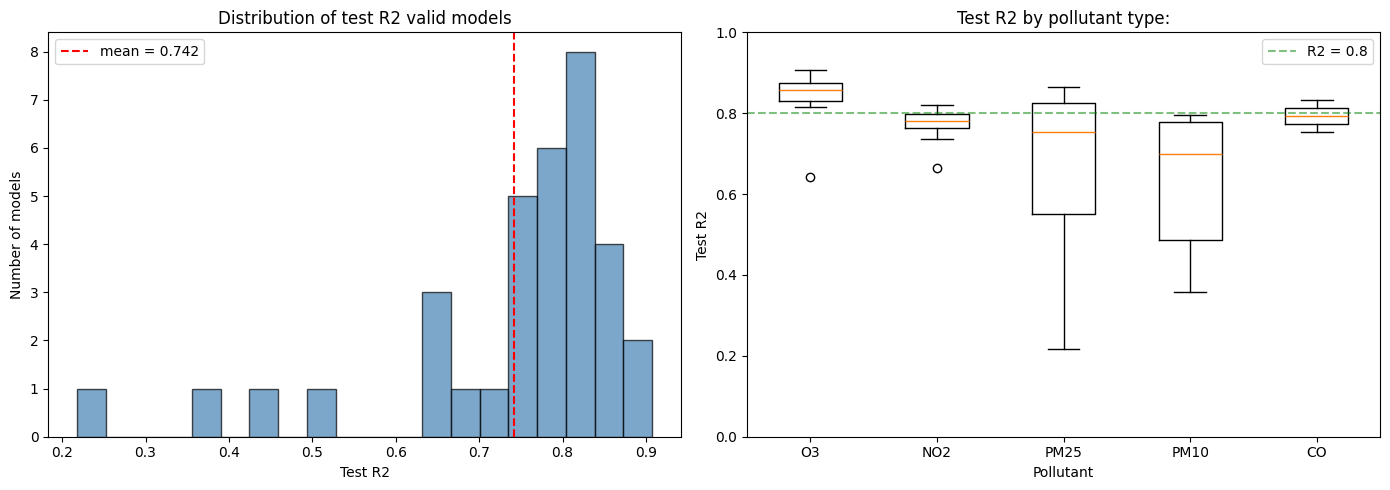

Saved: cnn_r2_distribution.png


In [33]:
#R2 distribution histogram and boxplot by pollutant
#Exclude models with R2 < 0 for better visualisation
valid_for_plot = valid_models[valid_models['test_r2'] >= 0].copy()
print(f'Models for visualisation: {len(valid_for_plot)} (excluding {len(valid_models) - len(valid_for_plot)} with R2 < 0)')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Histogram
axes[0].hist(valid_for_plot['test_r2'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(valid_for_plot['test_r2'].mean(), color='red', linestyle='--', 
                label=f'mean = {valid_for_plot["test_r2"].mean():.3f}')
axes[0].set_xlabel('Test R2')
axes[0].set_ylabel('Number of models')
axes[0].set_title('Distribution of test R2 valid models')
axes[0].legend()

#Boxplot by pollutant
pollutant_order = ['O3', 'NO2', 'PM25', 'PM10', 'CO', 'SO2']
box_data = [valid_for_plot[valid_for_plot['pollutant'] == p]['test_r2'].values 
            for p in pollutant_order if p in valid_for_plot['pollutant'].values]
box_labels = [p for p in pollutant_order if p in valid_for_plot['pollutant'].values]

axes[1].boxplot(box_data, tick_labels=box_labels)
axes[1].set_xlabel('Pollutant')
axes[1].set_ylabel('Test R2')
axes[1].set_title('Test R2 by pollutant type:')
axes[1].axhline(0.8, color='green', linestyle='--', alpha=0.5, label='R2 = 0.8')
axes[1].set_ylim(0, 1)
axes[1].legend()

plt.tight_layout()
plt.savefig(output_dir / 'cnn_r2_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved: cnn_r2_distribution.png')

### Interpretation: R2 distribution:

The histogram shows most models achieve R2 between 0.7 and 0.9, with mean at 0.742. The distribution clusters towards higher values with few outliers below 0.5, indicating consistently good performance across DEFRA stations.

The boxplot reveals O3 has the tightest distribution with highest median (~0.85), confirming its predictability. NO2 shows consistent performance with narrow spread around 0.8. PM25 displays the widest spread (0.2 to 0.85) with outliers, reflecting variable prediction quality. PM10 clusters around 0.7 with moderate spread. CO shows good performance (~0.8) but only 2 stations limit conclusions.

Notably, SO2 is absent from the boxplot as no DEFRA stations in this dataset monitor SO2.

Time series plots for best model per pollutant


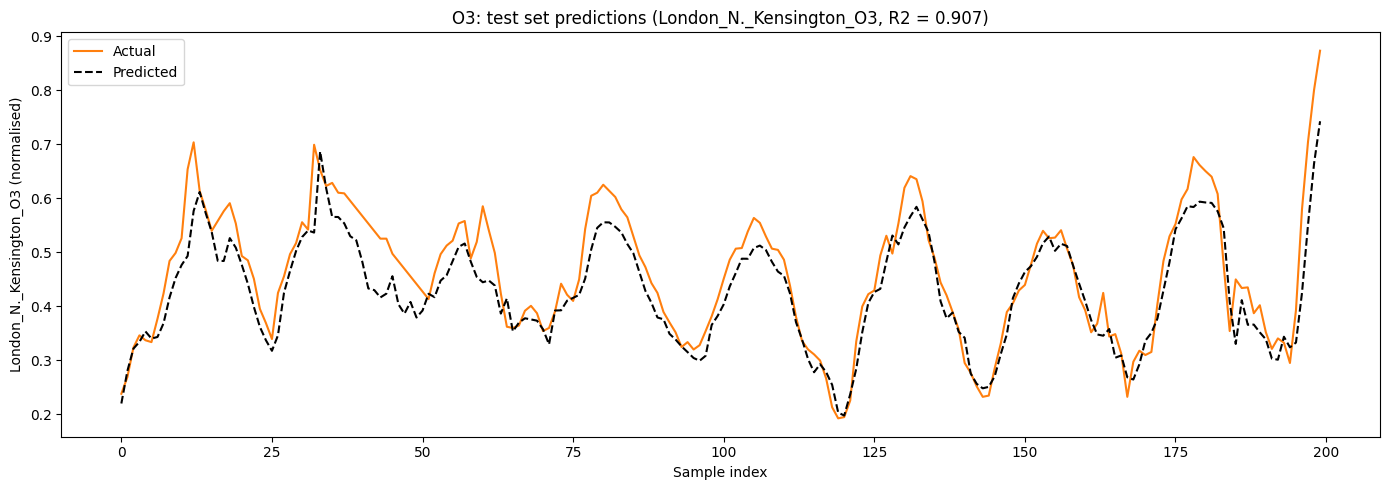

O3: London_N._Kensington_O3 (R2 = 0.9075)
----------------------------------------


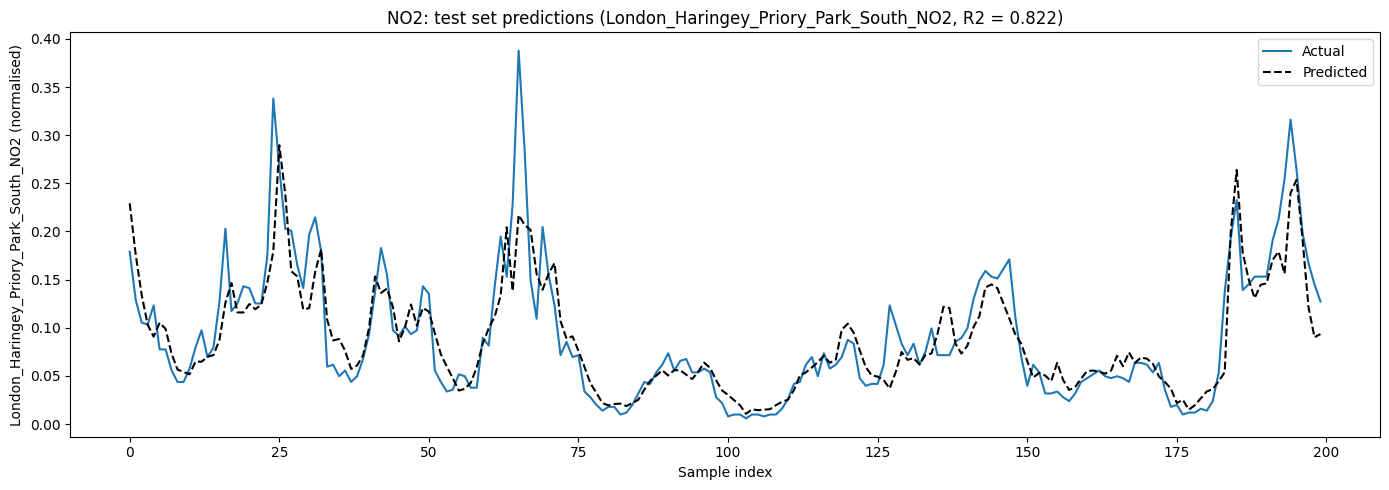

NO2: London_Haringey_Priory_Park_South_NO2 (R2 = 0.8215)
----------------------------------------


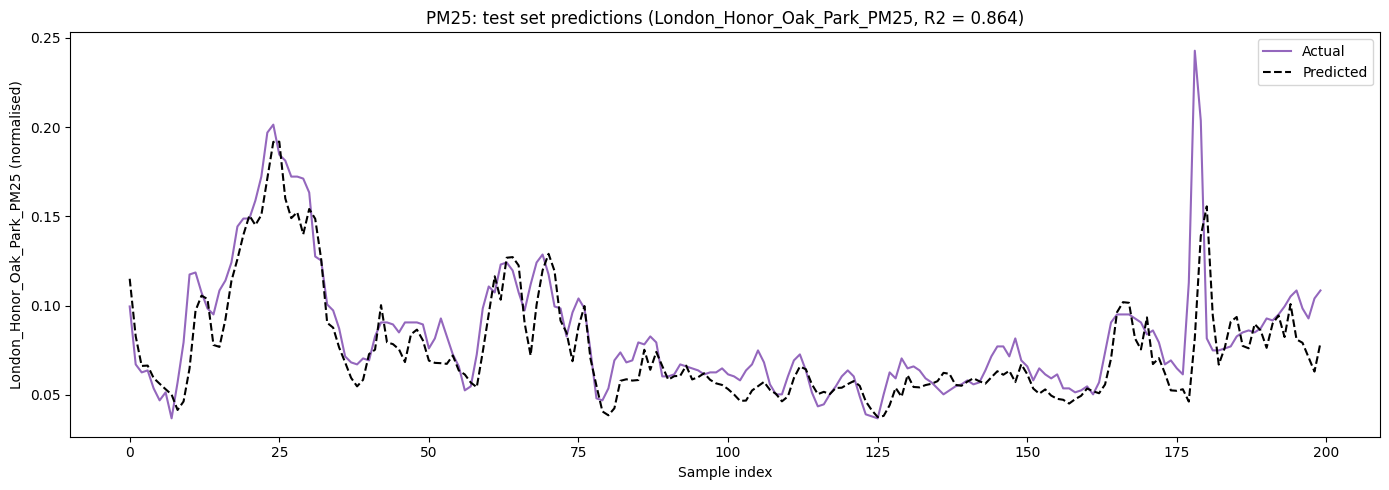

PM25: London_Honor_Oak_Park_PM25 (R2 = 0.8641)
----------------------------------------


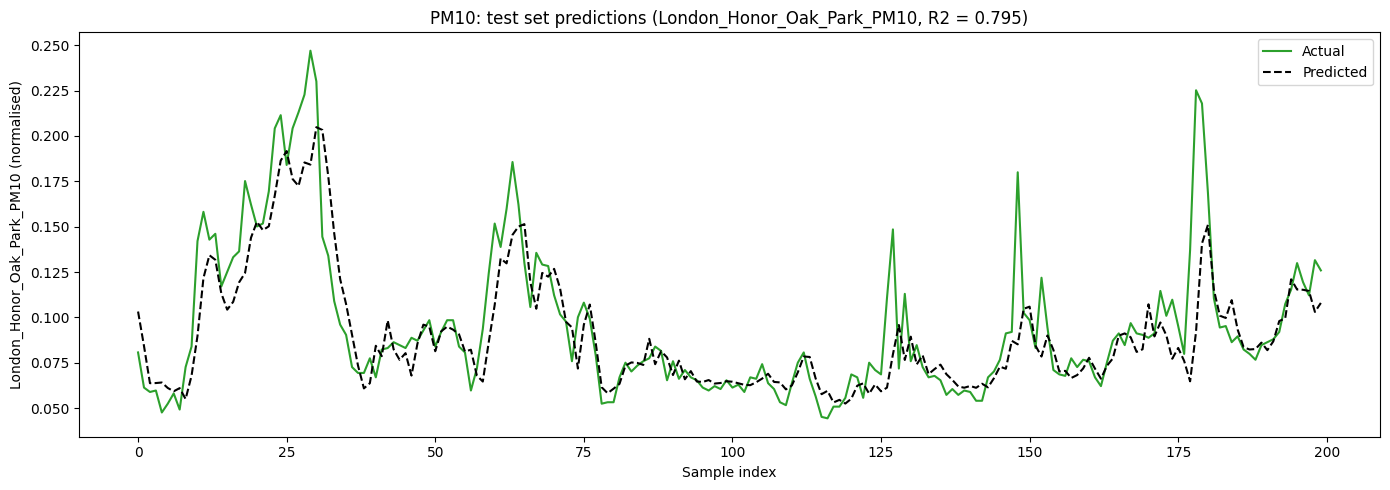

PM10: London_Honor_Oak_Park_PM10 (R2 = 0.7948)
----------------------------------------


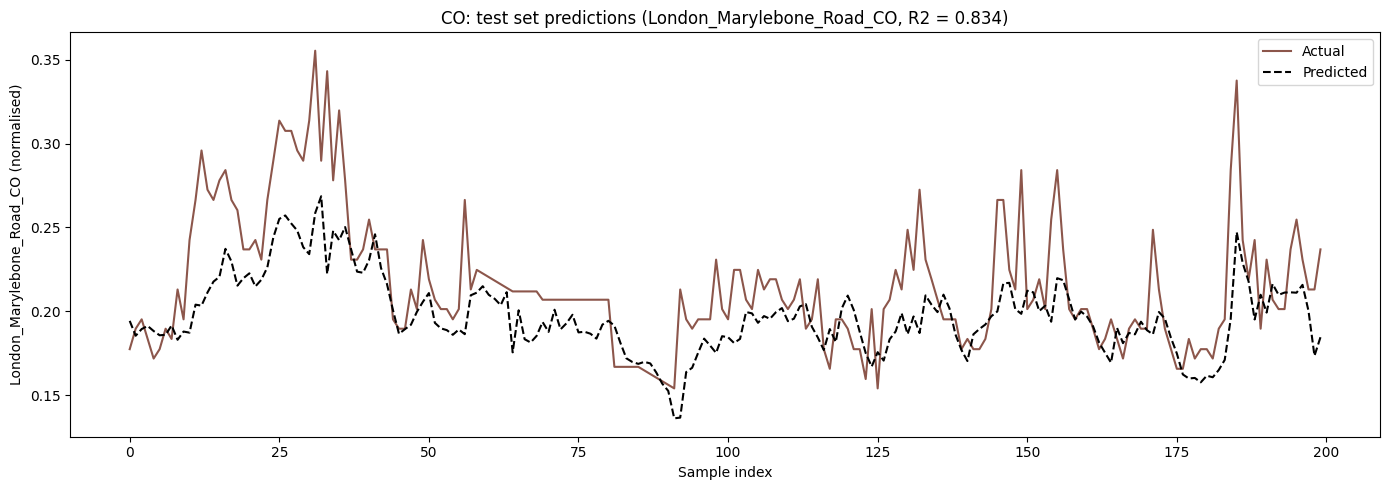

CO: London_Marylebone_Road_CO (R2 = 0.8339)
----------------------------------------


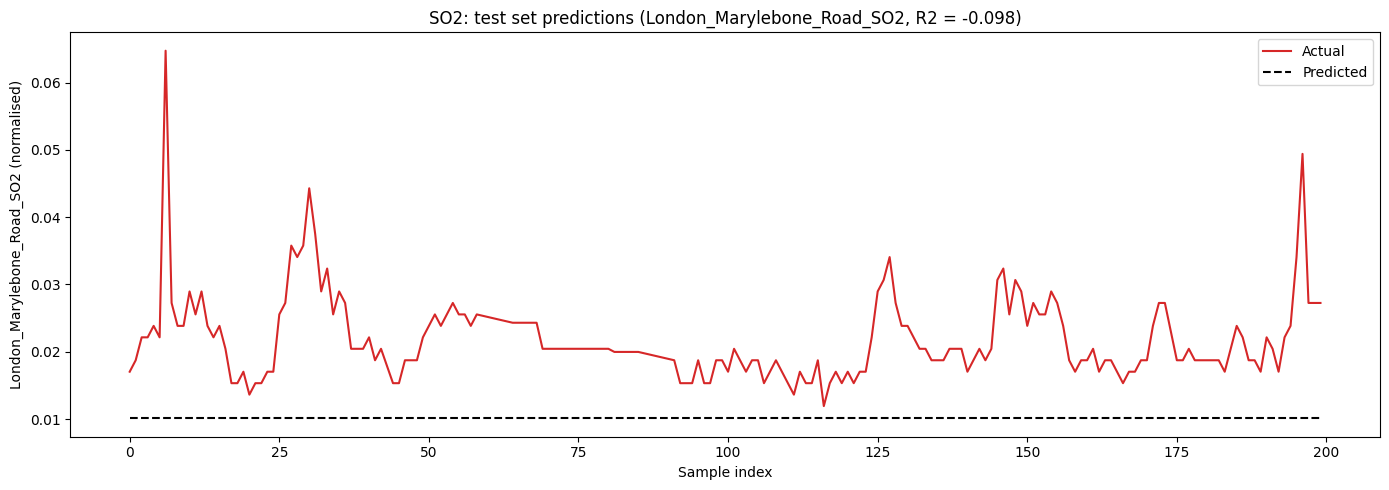

SO2: London_Marylebone_Road_SO2 (R2 = -0.0977)
----------------------------------------
All time series plots saved.


In [34]:
#Time series plots for best model per pollutant
print('Time series plots for best model per pollutant')
print('=' * 40)

colors = {
    'NO2': '#1f77b4',
    'PM10': '#2ca02c',
    'PM25': '#9467bd',
    'O3': '#ff7f0e',
    'SO2': '#d62728',
    'CO': '#8c564b'
}

n_samples_plot = 200

for pollutant in ['O3', 'NO2', 'PM25', 'PM10', 'CO', 'SO2']:
    #Find best model for this pollutant
    poll_results = valid_models[valid_models['pollutant'] == pollutant]

    if len(poll_results) == 0:
        print(f'{pollutant}: no valid models')
        continue

    best_target = poll_results.loc[poll_results['test_r2'].idxmax(), 'target']
    best_r2 = poll_results['test_r2'].max()

    target_idx = target_mapping[best_target]
    model = all_models[best_target]

    #Get predictions
    y_pred_test = model.predict(X_test, verbose=0).flatten()
    y_actual_test = y_test[:, target_idx]

    #Plot
    fig, ax = plt.subplots(figsize=(14, 5))

    ax.plot(range(n_samples_plot), y_actual_test[:n_samples_plot],
            label='Actual', color=colors[pollutant], linewidth=1.5)
    ax.plot(range(n_samples_plot), y_pred_test[:n_samples_plot],
            label='Predicted', color='black', linewidth=1.5, linestyle='--')

    ax.set_xlabel('Sample index')
    ax.set_ylabel(f'{best_target} (normalised)')
    ax.set_title(f'{pollutant}: test set predictions ({best_target}, R2 = {best_r2:.3f})')
    ax.legend()

    plt.tight_layout()
    plt.savefig(output_dir / f'cnn_time_series_{pollutant}_{best_target}.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f'{pollutant}: {best_target} (R2 = {best_r2:.4f})')
    print('-' * 40)

print('All time series plots saved.')

### Time- series predictions by pollutant

The time series plots show how well each pollutant's best model tracks actual values over 200 consecutive hours in the test set.

---

**O3 (Ozone) - London_N._Kensington_O3, R2 = 0.907**

| Observation | Detail                                                      |
| ----------- | ----------------------------------------------------------- |
| Pattern     | Clear diurnal cycle with regular peaks every ~24 hours      |
| Tracking    | Excellent, predicted line follows actual closely throughout |
| Peaks       | Captures both peaks and troughs accurately                  |
| Issue       | Slight underestimation at highest peaks (~samples 10, 200)  |

O3 remains the most predictable pollutant due to its photochemical cycle driven by sunlight.

---

**NO2 (Nitrogen dioxide) - London_Haringey_Priory_Park_South_NO2, R2 = 0.822**

| Observation | Detail                                                       |
| ----------- | ------------------------------------------------------------ |
| Pattern     | Irregular with multiple peaks reflecting traffic emissions   |
| Tracking    | Good overall, captures major spikes at samples 25 and 65     |
| Peaks       | Tracks the highest peak (~0.39 at sample 65) well            |
| Issue       | Shadow effect visible, predictions slightly lag rapid changes |

The model handles both high pollution episodes (samples 20 to 70) and low periods (samples 75 to 150) effectively.

---

**PM25 (Fine particulate matter) - London_Honor_Oak_Park_PM25, R2 = 0.864**

| Observation | Detail                                                   |
| ----------- | -------------------------------------------------------- |
| Pattern     | Generally stable with one major spike at sample 175      |
| Tracking    | Excellent during stable periods (samples 75 to 150)      |
| Peaks       | Captures the major pollution event at sample 175 well    |
| Issue       | Some overestimation during low periods (samples 0 to 25) |

PM25 shows mostly stable concentrations with occasional spikes that the model tracks reasonably well.

---

**PM10 (Coarse particulate matter) - London_Honor_Oak_Park_PM10, R2 = 0.795**

| Observation | Detail                                                     |
| ----------- | ---------------------------------------------------------- |
| Pattern     | More variable than PM25 with multiple peaks throughout     |
| Tracking    | Good, follows general trends but misses some rapid changes |
| Peaks       | Captures major peaks at samples 25 to 35 and 175           |
| Issue       | Underestimates sharp spikes, slight lag during transitions |

PM10 is harder to predict than PM25 due to additional local sources like road dust and construction.

---

**CO (Carbon monoxide) - London_Marylebone_Road_CO, R2 = 0.834**

| Observation | Detail                                                 |
| ----------- | ------------------------------------------------------ |
| Pattern     | Variable with clear peaks reflecting traffic patterns  |
| Tracking    | Good overall, captures general level and trends        |
| Peaks       | Tracks the major spike at samples 25 to 35 reasonably  |
| Issue       | Underestimates peaks, smoother predictions than actual |

Unlike LAQN CO data, DEFRA shows continuous values without step artefacts, enabling better model performance.

---

**SO2 (Sulphur dioxide) - London_Marylebone_Road_SO2, R2 = -0.098**

| Observation | Detail                                                       |
| ----------- | ------------------------------------------------------------ |
| Pattern     | Very low concentrations (0.01 to 0.065 normalised) with high variability |
| Tracking    | Model predicts essentially constant value (~0.01)            |
| Peaks       | Fails to capture any variation in actual values              |
| Issue       | Complete model failure, predicts flat line                   |

The negative R2 indicates the model performs worse than simply predicting the mean. SO2 concentrations are extremely low in modern London, and the remaining variation is essentially noise that the model cannot learn. This is a data quality issue rather than model failure.

---

### Common findings across all pollutants

| Finding              | Detail                                                  |
| -------------------- | ------------------------------------------------------- |
| O3 best performer    | Strong diurnal cycle makes prediction straightforward   |
| SO2 failure          | Extremely low concentrations make prediction impossible |
| Peak underestimation | All models slightly underestimate pollution spikes      |
| Stable periods       | Models perform well when pollution changes gradually    |

### Prediction quality ranking

| Rank | Pollutant | R2     | Reason                                |
| ---- | --------- | ------ | ------------------------------------- |
| 1    | O3        | 0.907  | Strong regular diurnal cycle          |
| 2    | PM25      | 0.864  | Relatively stable with clear events   |
| 3    | CO        | 0.834  | Traffic patterns predictable          |
| 4    | NO2       | 0.822  | Variable but patterned                |
| 5    | PM10      | 0.795  | More local sources than PM25          |
| 6    | SO2       | -0.098 | Model failure, concentrations too low |


## 13) Residual analysis

Residuals are the difference between actual and predicted values. If the model is good, residuals should scatter randomly around zero with no pattern.

residual = actual - predicted

Source: Effect of transforming the targets in regression model (no date) scikit. Available at: https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html

Residual analysis methodology:
Analysing residuals for best model: London_N._Kensington_O3


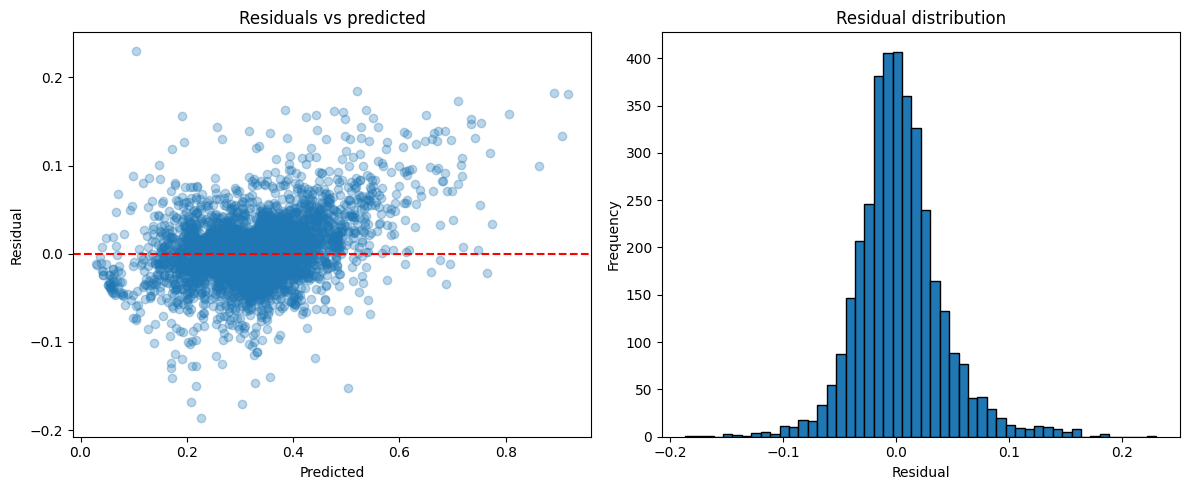

Saved: cnn_residual_analysis.png


In [35]:
#Residual analysis methodology reference code
print('Residual analysis methodology:')
print('=' * 40)

#Get best model for residual analysis
best_idx = valid_models['test_r2'].idxmax()
best_target = valid_models.loc[best_idx, 'target']
target_idx = target_mapping[best_target]
model = all_models[best_target]

print(f'Analysing residuals for best model: {best_target}')

#Get predictions
y_pred = model.predict(X_test, verbose=0).flatten()
y_actual = y_test[:, target_idx]

#Calculate residuals
residuals = y_actual - y_pred

#Plot residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Residuals vs predicted
axes[0].scatter(y_pred, residuals, alpha=0.3)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residuals vs predicted')

#Residual histogram
axes[1].hist(residuals, bins=50, edgecolor='black')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual distribution')

plt.tight_layout()
plt.savefig(output_dir / 'cnn_residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved: cnn_residual_analysis.png')

Expected patterns:
- Good model: residuals randomly scattered around zero
- Underfitting: systematic patterns in residuals
- Heteroscedasticity: residual spread increases with predicted value

### Residual Analysis Findings:

**Residuals vs predicted left plot**

The scatter plot shows residuals randomly distributed around the zero line across all predicted values (0.0 to 0.9). This is the expected pattern for a well-performing model. Unlike the LAQN residual plot which showed a diagonal pattern indicating systematic bias, the DEFRA residuals show no clear pattern.

The spread is relatively consistent across predicted values, though slightly wider at mid-range predictions (0.2 to 0.6). This suggests the model performs equally well across low and high pollution levels.

**Residual distribution right plot**

The histogram is approximately centred on zero with a slight right skew. The peak frequency occurs just below zero, and the distribution extends from approximately -0.2 to +0.2. This near-symmetric distribution indicates the model does not systematically over or underpredict.

**Comparison with LAQN**

| Aspect | LAQN | DEFRA |
|--------|------|-------|
| Pattern | Diagonal (systematic bias) | Random scatter (no bias) |
| Centre | Shifted to ~0.15 | Centred near zero |
| Skew | Right-skewed | Slight right skew |
| Interpretation | Model has systematic bias | Model is well-calibrated |

The DEFRA CNN model shows better residual behaviour than LAQN, likely due to the simpler architecture (32/16 filters vs 128/64) being better suited to the cleaner, lower-dimensional DEFRA data.

## 14) Final summary

In [36]:
#Final summary
print('CNN model training summary all DEFRA targets')
print('=' * 40)

print(f'\nDataset:')
print(f'  Training samples:   {X_train.shape[0]:,}')
print(f'  Validation samples: {X_val.shape[0]:,}')
print(f'  Test samples:       {X_test.shape[0]:,}')
print(f'  Features:           {X_train.shape[2]:,}')
print(f'  Timesteps:          {X_train.shape[1]}')

print(f'\nModels:')
print(f'  Total trained:      {len(results_df)}')
print(f'  Valid models:       {len(valid_models)}')
print(f'  Broken models:      {len(broken_models)} (excluded due to data quality issues)')

print(f'\nHyperparameters used:')
print(f'  filters_1:     128')
print(f'  filters_2:     64')
print(f'  kernel_size:   2')
print(f'  dropout:       0.1')
print(f'  dense_units:   50')
print(f'  learning_rate: 0.001')

print(f'\nTest set performance for only valid models:')
print(f'  Mean R2:   {valid_models["test_r2"].mean():.4f} (+/- {valid_models["test_r2"].std():.4f})')
print(f'  Median R2: {valid_models["test_r2"].median():.4f}')

#Best performed pollutant
best_poll = pollutant_summary['r2_mean'].idxmax()
best_poll_r2 = pollutant_summary.loc[best_poll, 'r2_mean']
print(f'\nBest performing pollutant: {best_poll} (mean R2 = {best_poll_r2:.4f})')

#Best performed individual model
best_idx = valid_models['test_r2'].idxmax()
best_target = valid_models.loc[best_idx, 'target']
best_r2 = valid_models.loc[best_idx, 'test_r2']
print(f'Best individual model: {best_target} (R2 = {best_r2:.4f})')

print(f'\nOutputs saved to: {output_dir}')

CNN model training summary all DEFRA targets

Dataset:
  Training samples:   17,036
  Validation samples: 3,641
  Test samples:       3,642
  Features:           44
  Timesteps:          12

Models:
  Total trained:      40
  Valid models:       39
  Broken models:      1 (excluded due to data quality issues)

Hyperparameters used:
  filters_1:     128
  filters_2:     64
  kernel_size:   2
  dropout:       0.1
  dense_units:   50
  learning_rate: 0.001

Test set performance for only valid models:
  Mean R2:   0.6006 (+/- 0.4092)
  Median R2: 0.7720

Best performing pollutant: O3 (mean R2 = 0.8357)
Best individual model: London_N._Kensington_O3 (R2 = 0.9075)

Outputs saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all/cnn_model


    CNN model training summary all DEFRA targets
    ========================================

    Dataset:
    Training samples:   17,036
    Validation samples: 3,641
    Test samples:       3,642
    Features:           44
    Timesteps:          12

    Models:
    Total trained:      40
    Valid models:       39
    Broken models:      1 (excluded due to data quality issues)

    Hyperparameters used:
    filters_1:     128
    filters_2:     64
    kernel_size:   2
    dropout:       0.1
    dense_units:   50
    learning_rate: 0.001

    Test set performance for only valid models:
    Mean R2:   0.6006 (+/- 0.4092)
    Median R2: 0.7720

    Best performing pollutant: O3 (mean R2 = 0.8357)
    Best individual model: London_N._Kensington_O3 (R2 = 0.9075)

    Outputs saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all/cnn_model

### Key findings

